In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from xgboost import XGBClassifier  # Or LightGBM, CatBoost
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import zipfile
import re
import sqlite3
from sqlalchemy import create_engine

# Create a SQLite database engine
database_name = "march_madness.sqlite"
engine = create_engine(f'sqlite:///{database_name}')

dataset_name = "march-machine-learning-mania-2025"
dataframes = {}
zip_filename = dataset_name + '.zip'

try:
    with zipfile.ZipFile(zip_filename, 'r') as zip_file:
        print("Files in the ZIP:", zip_file.namelist())
        
        for filename in zip_file.namelist():
            if filename.endswith('.csv'):
                # Create a clean table name
                table_name = filename.replace('.csv', '').replace(' _ ', '_').replace(' ', '_')
                table_name = re.sub(r'[^a-zA-Z0-9_]', '', table_name)  # Remove any special characters
                
                try:
                    # Special handling for TeamSpellings files
                    if 'TeamSpellings' in filename:
                        df = pd.read_csv(
                            zip_file.open(filename), 
                            encoding='latin1',
                            low_memory=False
                        )
                    else:
                        # Default UTF-8 encoding for other files
                        df = pd.read_csv(
                            zip_file.open(filename), 
                            low_memory=False
                        )
                    
                    # Write the dataframe to SQLite database
                    df.to_sql(table_name, engine, if_exists='replace', index=False)
                    print(f"Loaded and converted to SQL: {filename} -> {table_name}")
                    
                except Exception as e:
                    print(f"Error processing {filename}: {str(e)}")
                    
except FileNotFoundError:
    print(f"Could not find the zip file: {zip_filename}")
except zipfile.BadZipFile:
    print(f"The file {zip_filename} is not a valid zip file")
except Exception as e:
    print(f"An error occurred: {str(e)}")

# Example of how to query the database and convert to pandas dataframe
def query_to_dataframe(query):
    """
    Execute a SQL query and return the results as a pandas DataFrame
    """
    try:
        return pd.read_sql_query(query, engine)
    except Exception as e:
        print(f"Error executing query: {str(e)}")
        return None

# Example usage:
# df = query_to_dataframe("SELECT * FROM TableName LIMIT 5")


Files in the ZIP: ['Cities.csv', 'Conferences.csv', 'MConferenceTourneyGames.csv', 'MGameCities.csv', 'MMasseyOrdinals.csv', 'MNCAATourneyCompactResults.csv', 'MNCAATourneyDetailedResults.csv', 'MNCAATourneySeedRoundSlots.csv', 'MNCAATourneySeeds.csv', 'MNCAATourneySlots.csv', 'MRegularSeasonCompactResults.csv', 'MRegularSeasonDetailedResults.csv', 'MSeasons.csv', 'MSecondaryTourneyCompactResults.csv', 'MSecondaryTourneyTeams.csv', 'MTeamCoaches.csv', 'MTeamConferences.csv', 'MTeamSpellings.csv', 'MTeams.csv', 'SampleSubmissionStage1.csv', 'SampleSubmissionStage2.csv', 'SeedBenchmarkStage1.csv', 'WConferenceTourneyGames.csv', 'WGameCities.csv', 'WNCAATourneyCompactResults.csv', 'WNCAATourneyDetailedResults.csv', 'WNCAATourneySeeds.csv', 'WNCAATourneySlots.csv', 'WRegularSeasonCompactResults.csv', 'WRegularSeasonDetailedResults.csv', 'WSeasons.csv', 'WSecondaryTourneyCompactResults.csv', 'WSecondaryTourneyTeams.csv', 'WTeamConferences.csv', 'WTeamSpellings.csv', 'WTeams.csv']
Loaded and

# Feature Selection

As with prior years, each game has a unique ID created by concatenating the season in which the game was played and the two team's respective TeamIds. For example, "2025_1101_1102" indicates a hypothetical matchup between team 1101 and 1102 in the year 2025. You must predict the probability that the team with the lower TeamId beats the team with the higher TeamId. Note that the men's teams and women's TeamIds do not overlap.


In [3]:
# Show all columns
pd.set_option('display.max_columns', None)

query = """
select * from WRegularSeasonDetailedResults

UNION ALL
select * from MRegularSeasonDetailedResults



--Limit 5
"""
data = pd.read_sql_query(query,engine)
data.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2010,11,3103,63,3237,49,H,0,23,54,5,9,12,19,10,26,14,18,7,0,15,20,54,3,13,6,10,11,27,11,23,7,6,19
1,2010,11,3104,73,3399,68,N,0,26,62,5,12,16,28,16,31,15,20,5,2,25,25,63,4,21,14,27,14,26,7,20,4,2,27
2,2010,11,3110,71,3224,59,A,0,29,62,6,15,7,12,14,23,18,13,6,2,17,19,58,2,14,19,23,17,23,8,15,6,0,15
3,2010,11,3111,63,3267,58,A,0,27,52,4,11,5,9,6,40,14,27,5,10,18,18,74,6,26,16,25,22,22,15,11,14,5,14
4,2010,11,3119,74,3447,70,H,1,30,74,7,20,7,11,14,33,18,11,5,3,18,25,74,9,17,11,21,21,32,12,14,4,2,14


In [4]:

table_name ='AllRegularSeasonResults'
data.to_sql(table_name, engine, if_exists='replace', index=False)



198374

In [36]:
features_query = """
SELECT
    Season + 1 AS prediction_year,
    TeamID,
    AVG(WFGM - LFGM) AS average_score_difference,
    AVG(WFGM3) AS average_3_pointers,
    AVG(WFGA3) AS average_3_pointers_attempted,
    AVG(WFGM3) / NULLIF(AVG(WFGA3), 0) AS average_3_point_accuracy,
    AVG(WOR) AS average_offensive_rebound,
    AVG(WDR) AS average_defensive_rebound
FROM 
    (
        -- Combine the games where the team is the winner (Wteamid) and the loser (Lteamid)
        SELECT
            Season,
            Wteamid AS TeamID,
            WFGM, WFGM3, WFGA3, WOR, WDR, LFGM, LFGM3, LFGA3, LOR, LDR
        FROM AllRegularSeasonResults
        
        UNION ALL
        
        SELECT
            Season,
            Lteamid AS TeamID,
            LFGM, LFGM3, LFGA3, LOR, LDR, WFGM, WFGM3, WFGA3, WOR, WDR
        FROM AllRegularSeasonResults
    ) AS team_stats
WHERE 
    Season + 1 BETWEEN 2019 AND 2025
GROUP BY
    Season + 1, TeamID
"""
feature_df = pd.read_sql_query(features_query,engine)

In [32]:
from sqlalchemy import text
query = f"""
SELECT
    R.season,
    CASE 
        WHEN R.WTeamID < R.LTeamID THEN R.WTeamID
        ELSE R.LTeamID
    END AS Team1,
    CASE 
        WHEN R.WTeamID > R.LTeamID THEN R.WTeamID
        ELSE R.LTeamID
    END AS Team2,
    CASE
        WHEN (CASE 
            WHEN R.WTeamID < R.LTeamID THEN R.WTeamID
            ELSE R.LTeamID
        END) = R.WTeamID THEN 1
        ELSE 0
    END AS Team1_Won
FROM 
    AllRegularSeasonResults R
WHERE
    R.Season BETWEEN 2019 AND 2025
"""

# Execute the query using SQLAlchemy
with engine.connect() as connection:
    result = connection.execute(text(query))
    training_df = pd.DataFrame(result.fetchall(), columns=result.keys())

training_df.head()


,Season,Team1,Team2,Team1_Won
0,2019,3113,3230,1
1,2019,3120,3212,1
2,2019,3124,3311,1
3,2019,3135,3148,1
4,2019,3136,3262,1


In [25]:
# 1. Rename columns in feature_df to distinguish features for Team1 and Team2
feature_df_team1 = feature_df.rename(columns={
    'average_score_difference': 'Team1_WASD',
    'average_3_pointers': 'Team1_A3P',
    'average_3_pointers_attempted': 'Team1_A3PA',
    'average_3_point_accuracy': 'Team1_A3PAP',
    'average_offensive_rebound': 'Team1_AOR',
    'average_defensive_rebound': 'Team1_ADR',
})

feature_df_team2 = feature_df.rename(columns={
    'average_score_difference': 'Team2_WASD',
    'average_3_pointers': 'Team2_A3P',
    'average_3_pointers_attempted': 'Team2_A3PA',
    'average_3_point_accuracy': 'Team2_A3PAP',
    'average_offensive_rebound': 'Team2_AOR',
    'average_defensive_rebound': 'Team2_ADR',
})

# 2. Merge training_df with feature_df_team1 on the 'Season' and 'Team1' columns
training_with_team1_features = training_df.merge(
    feature_df_team1,
    how='left',  # Left join to keep all rows from training_df
    left_on=['Season', 'Team1'],
    right_on=['prediction_year', 'TeamID']
)

# 3. Merge training_with_team1_features with feature_df_team2 on the 'Season' and 'Team2' columns
training_with_both_features = training_with_team1_features.merge(
    feature_df_team2,
    how='left',  # Left join to keep all rows from training_with_team1_features
    left_on=['Season', 'Team2'],
    right_on=['prediction_year', 'TeamID']
)

# 4. Drop the unnecessary columns (like 'prediction_year' and 'TeamID' from both feature dataframes)
training_with_both_features = training_with_both_features.drop(columns=['prediction_year_x', 'TeamID_x', 'prediction_year_y','TeamID_y'])

# Now training_with_both_features has the features for both Team1 and Team2
training_with_both_features.sort_values(by=['Season','Team1','Team2'],ascending=True).head()


,Season,Team1,Team2,Team1_Won,Team1_WASD,Team1_A3P,Team1_A3PA,Team1_A3PAP,Team1_AOR,Team1_ADR,Team2_WASD,Team2_A3P,Team2_A3PA,Team2_A3PAP,Team2_AOR,Team2_ADR
29931,2019,1101,1117,1,0.740741,6.481481,19.962963,0.324675,9.037037,23.222222,-3.000000,7.233333,21.766667,0.332312,11.200000,22.100000
31049,2019,1101,1144,1,0.740741,6.481481,19.962963,0.324675,9.037037,23.222222,-0.500000,8.821429,23.428571,0.376524,6.785714,24.928571
33003,2019,1101,1146,1,0.740741,6.481481,19.962963,0.324675,9.037037,23.222222,-0.562500,8.375000,23.062500,0.363144,9.968750,25.875000
34616,2019,1101,1146,1,0.740741,6.481481,19.962963,0.324675,9.037037,23.222222,-0.562500,8.375000,23.062500,0.363144,9.968750,25.875000
30188,2019,1101,1176,1,0.740741,6.481481,19.962963,0.324675,9.037037,23.222222,0.642857,6.964286,17.642857,0.394737,10.107143,25.928571


In [27]:
def prepare_data(df):
    games = df
    # games['WTeamWon'] = 1
    # games_reversed = games[games.WTeamID < games.LTeamID].copy()
    # games_reversed[['WTeamID', 'LTeamID']] = games_reversed[['LTeamID', 'WTeamID']]
    # games_reversed['WTeamWon'] = 0
    # games = pd.concat((games, games_reversed), ignore_index=True)
    games['ID'] = games.apply(lambda r: '_'.join(map(str, [r['Season'], r['Team1'], r['Team2']])), axis=1)
    return games

training_with_both_features = prepare_data(training_with_both_features)
training_with_both_features.head()

,Season,Team1,Team2,Team1_Won,Team1_WASD,Team1_A3P,Team1_A3PA,Team1_A3PAP,Team1_AOR,Team1_ADR,Team2_WASD,Team2_A3P,Team2_A3PA,Team2_A3PAP,Team2_AOR,Team2_ADR,ID
0,2019,3113,3230,1,4.060606,4.787879,14.303030,0.334746,12.515152,24.242424,-7.285714,4.357143,17.785714,0.244980,12.607143,22.392857,2019.0_3113.0_3230.0
1,2019,3120,3212,1,3.535714,4.142857,15.250000,0.271663,14.142857,18.964286,0.500000,4.843750,17.437500,0.277778,12.093750,23.500000,2019.0_3120.0_3212.0
2,2019,3124,3311,1,14.031250,4.687500,12.406250,0.377834,15.000000,33.750000,-1.275862,5.275862,18.344828,0.287594,11.103448,25.034483,2019.0_3124.0_3311.0
3,2019,3135,3148,1,0.269231,7.807692,24.807692,0.314729,11.576923,28.807692,-6.066667,7.766667,22.666667,0.342647,11.500000,24.833333,2019.0_3135.0_3148.0
4,2019,3136,3262,1,-3.033333,3.233333,12.866667,0.251295,13.466667,26.600000,-5.344828,4.862069,16.275862,0.298729,11.931034,23.551724,2019.0_3136.0_3262.0


# Model Training

In [28]:
features = [
    'Team1_WASD',
    'Team1_A3P',
    'Team1_A3PA',
    'Team1_A3PAP',
    'Team1_AOR',
    'Team1_ADR',
    'Team2_WASD',
    'Team2_A3P',
    'Team2_A3PA',
    'Team2_A3PAP',
    'Team2_AOR',
    'Team2_ADR'
]

target = 'Team1_Won'

# Drop rows with NaN values
games = training_with_both_features.dropna(subset=features + [target])

x = games[features]
y = games[target]



In [29]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) 

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model_m = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')  # Added random_state for reproducibility, address deprecation warning
model_m.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Brier Score: 0.20924641390947155


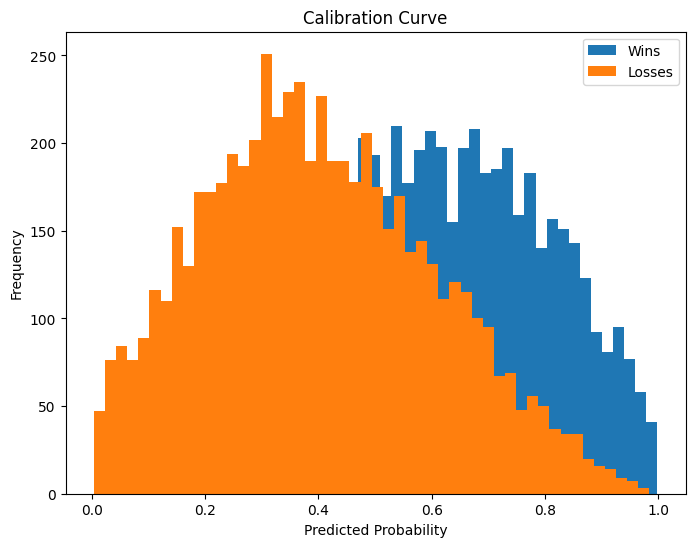

In [30]:
preds_m = model_m.predict_proba(X_test)[:, 1]
brier_score_m = brier_score_loss(y_test, preds_m)
print(f'Brier Score: {brier_score_m}')

# --- Visualization ---

def plot_calibration_curve(y_true, y_prob, title='Calibration Curve'):
    plt.figure(figsize=(8, 6))
    plt.hist(y_prob[y_true == 1], bins=50, label='Wins')
    plt.hist(y_prob[y_true == 0], bins=50, label='Losses')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend()
    plt.show()

plot_calibration_curve(y_test, preds_m, title='Calibration Curve')


# Submission

In [37]:
feature_df[feature_df['prediction_year'] == 2025].head()

,prediction_year,TeamID,average_score_difference,average_3_pointers,average_3_pointers_attempted,average_3_point_accuracy,average_offensive_rebound,average_defensive_rebound
4236,2025,1101,-1.419355,5.064516,14.806452,0.342048,7.806452,21.419355
4237,2025,1102,-1.516129,8.806452,24.419355,0.360634,6.419355,19.451613
4238,2025,1103,1.031250,7.500000,23.406250,0.320427,8.187500,23.875000
4239,2025,1104,3.281250,11.062500,30.281250,0.365325,11.031250,25.093750
4240,2025,1105,-1.454545,4.212121,14.787879,0.284836,9.424242,22.393939


In [40]:
query = f"""
SELECT 
    R.ID,
    SUBSTR(R.ID, 1, 4) AS Season,         
    SUBSTR(R.ID, 6, 4) AS Team1,        
    SUBSTR(R.ID, 11, 4) AS Team2,

    Team1.average_score_difference AS Team1_WASD,
    Team1.average_3_pointers AS Team1_A3P,
    Team1.average_3_pointers_attempted AS Team1_A3PA,
    Team1.average_3_point_accuracy AS Team1_A3PAP,
    Team1.average_offensive_rebound AS Team1_AOR,
    Team1.average_defensive_rebound AS Team1_ADR,

    Team2.average_score_difference AS Team2_WASD,
    Team2.average_3_pointers AS Team2_A3P,
    Team2.average_3_pointers_attempted AS Team2_A3PA,
    Team2.average_3_point_accuracy AS Team2_A3PAP,
    Team2.average_offensive_rebound AS Team2_AOR,
    Team2.average_defensive_rebound AS Team2_ADR

            
FROM SampleSubmissionStage2 R

LEFT JOIN
    ({features_query}) Team1
ON 
    Team1.prediction_year = cast(SUBSTR(R.ID, 1, 4) as int)
AND 
    Team1.teamid = cast(SUBSTR(R.ID, 6, 4) as int)

LEFT JOIN
    ({features_query}) Team2
ON 
    Team2.prediction_year = cast(SUBSTR(R.ID, 1, 4) as int)
AND 
    Team2.teamid = cast(SUBSTR(R.ID, 11, 4) as int)
"""
# Execute using SQLAlchemy
with engine.connect() as connection:
    result = connection.execute(text(query))
    submission_df = pd.DataFrame(result.fetchall(), columns=result.keys())


#submission_df[['Season', 'TeamID1', 'TeamID2']] = submission_df['ID'].apply(extract_game_info).tolist()
submission_df.head()

,ID,Season,Team1,Team2,Team1_WASD,Team1_A3P,Team1_A3PA,Team1_A3PAP,Team1_AOR,Team1_ADR,Team2_WASD,Team2_A3P,Team2_A3PA,Team2_A3PAP,Team2_AOR,Team2_ADR
0,2025_1101_1102,2025,1101,1102,-1.419355,5.064516,14.806452,0.342048,7.806452,21.419355,-1.516129,8.806452,24.419355,0.360634,6.419355,19.451613
1,2025_1101_1103,2025,1101,1103,-1.419355,5.064516,14.806452,0.342048,7.806452,21.419355,1.031250,7.500000,23.406250,0.320427,8.187500,23.875000
2,2025_1101_1104,2025,1101,1104,-1.419355,5.064516,14.806452,0.342048,7.806452,21.419355,3.281250,11.062500,30.281250,0.365325,11.031250,25.093750
3,2025_1101_1105,2025,1101,1105,-1.419355,5.064516,14.806452,0.342048,7.806452,21.419355,-1.454545,4.212121,14.787879,0.284836,9.424242,22.393939
4,2025_1101_1106,2025,1101,1106,-1.419355,5.064516,14.806452,0.342048,7.806452,21.419355,0.000000,6.931034,24.724138,0.280335,11.275862,22.655172


In [41]:
z = submission_df[features]
z

,Team1_WASD,Team1_A3P,Team1_A3PA,Team1_A3PAP,Team1_AOR,Team1_ADR,Team2_WASD,Team2_A3P,Team2_A3PA,Team2_A3PAP,Team2_AOR,Team2_ADR
0,-1.419355,5.064516,14.806452,0.342048,7.806452,21.419355,-1.516129,8.806452,24.419355,0.360634,6.419355,19.451613
1,-1.419355,5.064516,14.806452,0.342048,7.806452,21.419355,1.031250,7.500000,23.406250,0.320427,8.187500,23.875000
2,-1.419355,5.064516,14.806452,0.342048,7.806452,21.419355,3.281250,11.062500,30.281250,0.365325,11.031250,25.093750
3,-1.419355,5.064516,14.806452,0.342048,7.806452,21.419355,-1.454545,4.212121,14.787879,0.284836,9.424242,22.393939
4,-1.419355,5.064516,14.806452,0.342048,7.806452,21.419355,0.000000,6.931034,24.724138,0.280335,11.275862,22.655172
...,...,...,...,...,...,...,...,...,...,...,...,...
131402,-3.206897,6.931034,21.137931,0.327896,7.620690,25.931034,NaN,NaN,NaN,NaN,NaN,NaN
131403,-3.206897,6.931034,21.137931,0.327896,7.620690,25.931034,NaN,NaN,NaN,NaN,NaN,NaN
131404,-1.593750,4.593750,16.218750,0.283237,10.343750,21.187500,NaN,NaN,NaN,NaN,NaN,NaN
131405,-1.593750,4.593750,16.218750,0.283237,10.343750,21.187500,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
pred = model_m.predict_proba(z)[:, 1]
submission_df['Pred']=np.floor(pred * 10) / 10
submission_df.head()

,ID,Season,Team1,Team2,Team1_WASD,Team1_A3P,Team1_A3PA,Team1_A3PAP,Team1_AOR,Team1_ADR,Team2_WASD,Team2_A3P,Team2_A3PA,Team2_A3PAP,Team2_AOR,Team2_ADR,Pred
0,2025_1101_1102,2025,1101,1102,-1.419355,5.064516,14.806452,0.342048,7.806452,21.419355,-1.516129,8.806452,24.419355,0.360634,6.419355,19.451613,0.2
1,2025_1101_1103,2025,1101,1103,-1.419355,5.064516,14.806452,0.342048,7.806452,21.419355,1.031250,7.500000,23.406250,0.320427,8.187500,23.875000,0.4
2,2025_1101_1104,2025,1101,1104,-1.419355,5.064516,14.806452,0.342048,7.806452,21.419355,3.281250,11.062500,30.281250,0.365325,11.031250,25.093750,0.2
3,2025_1101_1105,2025,1101,1105,-1.419355,5.064516,14.806452,0.342048,7.806452,21.419355,-1.454545,4.212121,14.787879,0.284836,9.424242,22.393939,0.2
4,2025_1101_1106,2025,1101,1106,-1.419355,5.064516,14.806452,0.342048,7.806452,21.419355,0.000000,6.931034,24.724138,0.280335,11.275862,22.655172,0.1


In [43]:
submission_df.tail()

,ID,Season,Team1,Team2,Team1_WASD,Team1_A3P,Team1_A3PA,Team1_A3PAP,Team1_AOR,Team1_ADR,Team2_WASD,Team2_A3P,Team2_A3PA,Team2_A3PAP,Team2_AOR,Team2_ADR,Pred
131402,2025_3477_3479,2025,3477,3479,-3.206897,6.931034,21.137931,0.327896,7.62069,25.931034,NaN,NaN,NaN,NaN,NaN,NaN,0.0
131403,2025_3477_3480,2025,3477,3480,-3.206897,6.931034,21.137931,0.327896,7.62069,25.931034,NaN,NaN,NaN,NaN,NaN,NaN,0.0
131404,2025_3478_3479,2025,3478,3479,-1.593750,4.593750,16.218750,0.283237,10.34375,21.187500,NaN,NaN,NaN,NaN,NaN,NaN,0.0
131405,2025_3478_3480,2025,3478,3480,-1.593750,4.593750,16.218750,0.283237,10.34375,21.187500,NaN,NaN,NaN,NaN,NaN,NaN,0.0
131406,2025_3479_3480,2025,3479,3480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3


In [44]:
# Drop unnecessary columns
submission_df = submission_df[['ID', 'Pred']].fillna(0.5)



In [45]:
# Preview your submission 
submission_df.sort_values(by='Pred', ascending = True).head()

,ID,Pred
60338,2025_1369_1421,0.0
62495,2025_1392_1480,0.0
22790,2025_1176_1268,0.0
62500,2025_1393_1398,0.0
22785,2025_1176_1263,0.0


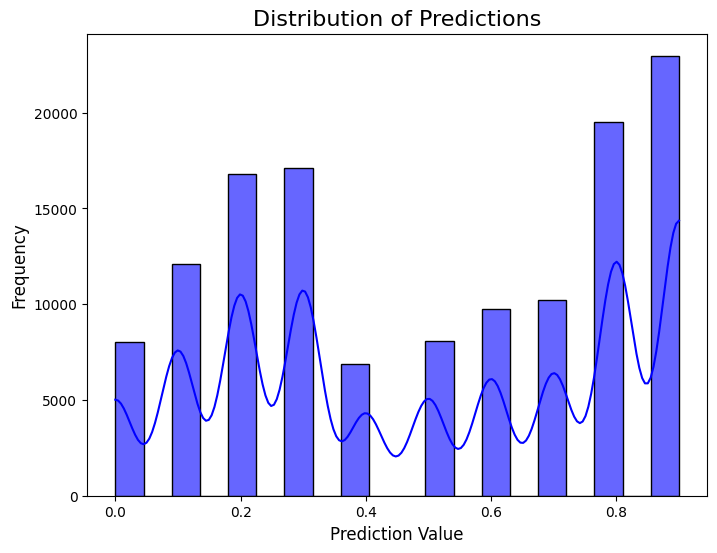

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your submission dataframe is named `submission_df`
# Plotting the distribution of the 'Pred' column
plt.figure(figsize=(8, 6))
sns.histplot(submission_df['Pred'], kde=True, bins=20, color='blue', alpha=0.6)

# Adding labels and title
plt.title('Distribution of Predictions', fontsize=16)
plt.xlabel('Prediction Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Show the plot
plt.show()


In [46]:
submission_df.to_csv('submission.csv',index=False)